In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
CENTERNET_TASK = "ctdet"
CENTERNET_MODEL_PATH = "/home/adrian/projects/CenterNet/models/ctdet_coco_dla_2x.pth"

data_dir='/home/adrian/data'
data_split='val2017'
annFile=f'{data_dir}/coco/annotations/instances_{data_split}.json'

classes = ("person", "dog", "motorcycle", "bear")

In [3]:
import torch.utils.data as data
from PIL import Image
import os
from datasets import ImageDataset, COCODataset

In [4]:
from torchvision import transforms
import torch.nn.functional as F
import torch

def pad_to_size(img: torch.Tensor, size):
    padded = torch.zeros(img.shape[0], size[1], size[0])
    padded[:, :img.shape[1], :img.shape[2]] = img
    return padded

mean, std = 0.1307, 0.3081
train_dataset = ImageDataset("/home/adrian/data/classy_coconut/train",
                             classes,
                               tfm=transforms.Compose([
                                 transforms.Normalize((mean,), (std,)),
                                 lambda x: pad_to_size(x, (512, 512))
                             ]))
dev_dataset = ImageDataset('/home/adrian/data/classy_coconut/dev',
                            classes,
                            tfm=transforms.Compose([
                                transforms.Normalize((mean,), (std,)),
                                lambda x: pad_to_size(x, (512, 512))
                            ]))
n_classes = len(classes)

In [5]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf', '#800080', '#808000', '#F08080']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [6]:
# Set up data loaders
batch_size = 8
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [7]:
fit(train_loader, dev_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/home/adrian/miniconda3/envs/julia/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/2953 (0%)]	Loss: 1.878718	Accuracy: 0.0


Train: [400/2953 (14%)]	Loss: 224.305994	Accuracy: 64.2156862745098


Train: [800/2953 (27%)]	Loss: 5.857925	Accuracy: 74.5049504950495


Train: [1200/2953 (41%)]	Loss: 9.606315	Accuracy: 77.06953642384106


Train: [1600/2953 (54%)]	Loss: 3.367539	Accuracy: 78.60696517412936


Train: [2000/2953 (68%)]	Loss: 0.561730	Accuracy: 80.92629482071713


Train: [2400/2953 (81%)]	Loss: 1.113376	Accuracy: 82.47508305647841


Train: [2800/2953 (95%)]	Loss: 2.241664	Accuracy: 83.19088319088318


Epoch: 1/20. Train set: Average loss: 33.4218	Accuracy: 83.44056891296987
Epoch: 1/20. Validation set: Average loss: 11.5999	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.148678	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.664293	Accuracy: 90.93137254901961


Train: [800/2953 (27%)]	Loss: 0.436587	Accuracy: 91.2128712871287


Train: [1200/2953 (41%)]	Loss: 0.552608	Accuracy: 89.98344370860927


Train: [1600/2953 (54%)]	Loss: 0.418730	Accuracy: 90.11194029850746


Train: [2000/2953 (68%)]	Loss: 0.469821	Accuracy: 90.08964143426294


Train: [2400/2953 (81%)]	Loss: 0.437008	Accuracy: 89.95016611295681


Train: [2800/2953 (95%)]	Loss: 0.356915	Accuracy: 90.17094017094017


Epoch: 2/20. Train set: Average loss: 0.4685	Accuracy: 90.28107009820522
Epoch: 2/20. Validation set: Average loss: 3.6606	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.100255	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.381869	Accuracy: 91.17647058823529


Train: [800/2953 (27%)]	Loss: 0.357071	Accuracy: 91.33663366336634


Train: [1200/2953 (41%)]	Loss: 0.417959	Accuracy: 90.72847682119205


Train: [1600/2953 (54%)]	Loss: 0.375153	Accuracy: 90.79601990049751


Train: [2000/2953 (68%)]	Loss: 0.384116	Accuracy: 90.73705179282868


Train: [2400/2953 (81%)]	Loss: 0.427172	Accuracy: 90.49003322259136


Train: [2800/2953 (95%)]	Loss: 0.379463	Accuracy: 90.45584045584046


Epoch: 3/20. Train set: Average loss: 0.3928	Accuracy: 90.28107009820522
Epoch: 3/20. Validation set: Average loss: 2.8690	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.115493	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.364047	Accuracy: 91.42156862745098


Train: [800/2953 (27%)]	Loss: 0.317110	Accuracy: 91.70792079207921


Train: [1200/2953 (41%)]	Loss: 0.372113	Accuracy: 91.47350993377484


Train: [1600/2953 (54%)]	Loss: 0.439154	Accuracy: 90.73383084577114


Train: [2000/2953 (68%)]	Loss: 0.357546	Accuracy: 90.78685258964144


Train: [2400/2953 (81%)]	Loss: 0.463918	Accuracy: 90.40697674418605


Train: [2800/2953 (95%)]	Loss: 0.365510	Accuracy: 90.42022792022792


Epoch: 4/20. Train set: Average loss: 0.3844	Accuracy: 90.28107009820522
Epoch: 4/20. Validation set: Average loss: 3.2655	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.091960	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.342934	Accuracy: 90.93137254901961


Train: [800/2953 (27%)]	Loss: 0.395835	Accuracy: 90.0990099009901


Train: [1200/2953 (41%)]	Loss: 0.365023	Accuracy: 90.48013245033113


Train: [1600/2953 (54%)]	Loss: 0.329908	Accuracy: 90.6094527363184


Train: [2000/2953 (68%)]	Loss: 0.384723	Accuracy: 90.63745019920319


Train: [2400/2953 (81%)]	Loss: 0.347376	Accuracy: 90.61461794019934


Train: [2800/2953 (95%)]	Loss: 0.436071	Accuracy: 90.27777777777777


Epoch: 5/20. Train set: Average loss: 0.3827	Accuracy: 90.24720623095158
Epoch: 5/20. Validation set: Average loss: 2.7981	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.677770	Accuracy: 75.0


Train: [400/2953 (14%)]	Loss: 0.352522	Accuracy: 91.66666666666667


Train: [800/2953 (27%)]	Loss: 0.641363	Accuracy: 89.85148514851485


Train: [1200/2953 (41%)]	Loss: 0.392359	Accuracy: 90.97682119205298


Train: [1600/2953 (54%)]	Loss: 0.345833	Accuracy: 91.16915422885572


Train: [2000/2953 (68%)]	Loss: 0.387161	Accuracy: 91.18525896414343


Train: [2400/2953 (81%)]	Loss: 0.458264	Accuracy: 90.69767441860465


Train: [2800/2953 (95%)]	Loss: 0.514227	Accuracy: 90.31339031339031


Epoch: 6/20. Train set: Average loss: 0.4447	Accuracy: 90.34879783271249
Epoch: 6/20. Validation set: Average loss: 5.8554	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.056102	Accuracy: 100.0

Train: [400/2953 (14%)]	Loss: 0.400332	Accuracy: 91.42156862745098


Train: [800/2953 (27%)]	Loss: 0.361901	Accuracy: 90.96534653465346


Train: [1200/2953 (41%)]	Loss: 0.430786	Accuracy: 90.31456953642385


Train: [1600/2953 (54%)]	Loss: 0.453489	Accuracy: 89.92537313432835


Train: [2000/2953 (68%)]	Loss: 0.402321	Accuracy: 90.0398406374502


Train: [2400/2953 (81%)]	Loss: 0.482085	Accuracy: 89.95016611295681


Train: [2800/2953 (95%)]	Loss: 0.390184	Accuracy: 90.02849002849003


Epoch: 7/20. Train set: Average loss: 0.4087	Accuracy: 90.21334236369793
Epoch: 7/20. Validation set: Average loss: 4.9917	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.858654	Accuracy: 75.0


Train: [400/2953 (14%)]	Loss: 0.497637	Accuracy: 87.5


Train: [800/2953 (27%)]	Loss: 0.300144	Accuracy: 89.97524752475248


Train: [1200/2953 (41%)]	Loss: 0.396541	Accuracy: 89.90066225165563


Train: [1600/2953 (54%)]	Loss: 0.389771	Accuracy: 89.98756218905473


Train: [2000/2953 (68%)]	Loss: 0.397200	Accuracy: 89.8406374501992


Train: [2400/2953 (81%)]	Loss: 0.345322	Accuracy: 90.1578073089701


Train: [2800/2953 (95%)]	Loss: 0.363471	Accuracy: 90.20655270655271


Epoch: 8/20. Train set: Average loss: 0.3823	Accuracy: 90.28107009820522
Epoch: 8/20. Validation set: Average loss: 3.9417	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.806477	Accuracy: 75.0


Train: [400/2953 (14%)]	Loss: 0.396022	Accuracy: 89.46078431372548


Train: [800/2953 (27%)]	Loss: 0.338741	Accuracy: 90.47029702970298


Train: [1200/2953 (41%)]	Loss: 0.327156	Accuracy: 90.8112582781457


Train: [1600/2953 (54%)]	Loss: 0.378342	Accuracy: 90.6094527363184


Train: [2000/2953 (68%)]	Loss: 0.407045	Accuracy: 90.43824701195219


Train: [2400/2953 (81%)]	Loss: 0.327688	Accuracy: 90.61461794019934


Train: [2800/2953 (95%)]	Loss: 0.393399	Accuracy: 90.34900284900284


Epoch: 9/20. Train set: Average loss: 0.3686	Accuracy: 90.28107009820522
Epoch: 9/20. Validation set: Average loss: 3.7090	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.854125	Accuracy: 75.0


Train: [400/2953 (14%)]	Loss: 0.364122	Accuracy: 89.70588235294117


Train: [800/2953 (27%)]	Loss: 0.379080	Accuracy: 89.85148514851485


Train: [1200/2953 (41%)]	Loss: 0.349843	Accuracy: 90.06622516556291


Train: [1600/2953 (54%)]	Loss: 0.323645	Accuracy: 90.54726368159204


Train: [2000/2953 (68%)]	Loss: 0.386238	Accuracy: 90.2390438247012


Train: [2400/2953 (81%)]	Loss: 0.385306	Accuracy: 90.07475083056478


Train: [2800/2953 (95%)]	Loss: 0.318897	Accuracy: 90.24216524216524


Epoch: 10/20. Train set: Average loss: 0.3584	Accuracy: 90.28107009820522
Epoch: 10/20. Validation set: Average loss: 3.8484	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.490905	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 0.347869	Accuracy: 90.93137254901961


Train: [800/2953 (27%)]	Loss: 0.400380	Accuracy: 89.85148514851485


Train: [1200/2953 (41%)]	Loss: 0.360468	Accuracy: 89.81788079470199


Train: [1600/2953 (54%)]	Loss: 0.379965	Accuracy: 89.80099502487562


Train: [2000/2953 (68%)]	Loss: 0.331620	Accuracy: 89.99003984063745


Train: [2400/2953 (81%)]	Loss: 0.279611	Accuracy: 90.32392026578073


Train: [2800/2953 (95%)]	Loss: 0.329672	Accuracy: 90.45584045584046


Epoch: 11/20. Train set: Average loss: 0.3475	Accuracy: 90.41652556721978
Epoch: 11/20. Validation set: Average loss: 4.5192	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.458048	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 0.352680	Accuracy: 88.72549019607843


Train: [800/2953 (27%)]	Loss: 0.392669	Accuracy: 90.0990099009901


Train: [1200/2953 (41%)]	Loss: 0.434823	Accuracy: 89.48675496688742


Train: [1600/2953 (54%)]	Loss: 0.356974	Accuracy: 89.73880597014926


Train: [2000/2953 (68%)]	Loss: 0.383157	Accuracy: 89.7410358565737


Train: [2400/2953 (81%)]	Loss: 0.360267	Accuracy: 89.95016611295681


Train: [2800/2953 (95%)]	Loss: 0.311434	Accuracy: 90.27777777777777


Epoch: 12/20. Train set: Average loss: 0.3656	Accuracy: 90.38266169996614
Epoch: 12/20. Validation set: Average loss: 4.1328	Accuracy: 24.489795918367346


Train: [0/2953 (0%)]	Loss: 0.412024	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 0.361045	Accuracy: 89.46078431372548


Train: [800/2953 (27%)]	Loss: 0.329109	Accuracy: 90.0990099009901


Train: [1200/2953 (41%)]	Loss: 0.342201	Accuracy: 90.6456953642384


Train: [1600/2953 (54%)]	Loss: 0.400450	Accuracy: 90.17412935323384


Train: [2000/2953 (68%)]	Loss: 0.329191	Accuracy: 90.38844621513944


Train: [2400/2953 (81%)]	Loss: 0.323162	Accuracy: 90.4485049833887


Train: [2800/2953 (95%)]	Loss: 0.313005	Accuracy: 90.5982905982906


Epoch: 13/20. Train set: Average loss: 0.3455	Accuracy: 90.58584490348798
Epoch: 13/20. Validation set: Average loss: 4.3487	Accuracy: 25.510204081632654


Train: [0/2953 (0%)]	Loss: 0.446911	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 0.279143	Accuracy: 92.40196078431373


Train: [800/2953 (27%)]	Loss: 0.342786	Accuracy: 91.46039603960396


Train: [1200/2953 (41%)]	Loss: 0.345302	Accuracy: 90.89403973509934


Train: [1600/2953 (54%)]	Loss: 0.325553	Accuracy: 90.98258706467662


Train: [2000/2953 (68%)]	Loss: 0.290023	Accuracy: 91.33466135458167


Train: [2400/2953 (81%)]	Loss: 0.409249	Accuracy: 90.86378737541528


Train: [2800/2953 (95%)]	Loss: 0.322583	Accuracy: 90.88319088319088


Epoch: 14/20. Train set: Average loss: 0.3332	Accuracy: 90.72130037250254
Epoch: 14/20. Validation set: Average loss: 4.4487	Accuracy: 25.510204081632654


Train: [0/2953 (0%)]	Loss: 0.085051	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.300192	Accuracy: 91.91176470588235


Train: [800/2953 (27%)]	Loss: 0.344908	Accuracy: 90.96534653465346


Train: [1200/2953 (41%)]	Loss: 0.286898	Accuracy: 91.63907284768212


Train: [1600/2953 (54%)]	Loss: 0.351787	Accuracy: 91.04477611940298


Train: [2000/2953 (68%)]	Loss: 0.341042	Accuracy: 91.03585657370517


Train: [2400/2953 (81%)]	Loss: 0.292459	Accuracy: 91.19601328903654


Train: [2800/2953 (95%)]	Loss: 0.315813	Accuracy: 91.23931623931624


Epoch: 15/20. Train set: Average loss: 0.3190	Accuracy: 91.22925838130715
Epoch: 15/20. Validation set: Average loss: 4.1649	Accuracy: 25.510204081632654


Train: [0/2953 (0%)]	Loss: 0.065024	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.323981	Accuracy: 90.68627450980392


Train: [800/2953 (27%)]	Loss: 0.290212	Accuracy: 91.46039603960396


Train: [1200/2953 (41%)]	Loss: 0.270348	Accuracy: 91.72185430463576


Train: [1600/2953 (54%)]	Loss: 0.321556	Accuracy: 91.85323383084577


Train: [2000/2953 (68%)]	Loss: 0.345039	Accuracy: 91.43426294820718


Train: [2400/2953 (81%)]	Loss: 0.284798	Accuracy: 91.65282392026577


Train: [2800/2953 (95%)]	Loss: 0.287485	Accuracy: 91.7022792022792


Epoch: 16/20. Train set: Average loss: 0.3029	Accuracy: 91.66948865560447
Epoch: 16/20. Validation set: Average loss: 4.5736	Accuracy: 25.510204081632654


Train: [0/2953 (0%)]	Loss: 0.451014	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 0.315664	Accuracy: 91.17647058823529


Train: [800/2953 (27%)]	Loss: 0.292865	Accuracy: 91.70792079207921


Train: [1200/2953 (41%)]	Loss: 0.283255	Accuracy: 91.97019867549669


Train: [1600/2953 (54%)]	Loss: 0.340358	Accuracy: 91.66666666666667


Train: [2000/2953 (68%)]	Loss: 0.263597	Accuracy: 91.9820717131474


Train: [2400/2953 (81%)]	Loss: 0.275453	Accuracy: 91.90199335548172


Train: [2800/2953 (95%)]	Loss: 0.328458	Accuracy: 91.66666666666667


Epoch: 17/20. Train set: Average loss: 0.2972	Accuracy: 91.73721639011175
Epoch: 17/20. Validation set: Average loss: 4.9043	Accuracy: 26.53061224489796


Train: [0/2953 (0%)]	Loss: 0.033408	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.267018	Accuracy: 92.8921568627451


Train: [800/2953 (27%)]	Loss: 0.320781	Accuracy: 91.58415841584159


Train: [1200/2953 (41%)]	Loss: 0.342654	Accuracy: 91.05960264900662


Train: [1600/2953 (54%)]	Loss: 0.285015	Accuracy: 91.35572139303483


Train: [2000/2953 (68%)]	Loss: 0.321224	Accuracy: 91.23505976095618


Train: [2400/2953 (81%)]	Loss: 0.247987	Accuracy: 91.56976744186046


Train: [2800/2953 (95%)]	Loss: 0.268994	Accuracy: 91.84472934472934


Epoch: 18/20. Train set: Average loss: 0.2939	Accuracy: 91.73721639011175
Epoch: 18/20. Validation set: Average loss: 5.2139	Accuracy: 26.53061224489796


Train: [0/2953 (0%)]	Loss: 0.077353	Accuracy: 100.0


Train: [400/2953 (14%)]	Loss: 0.334643	Accuracy: 91.42156862745098


Train: [800/2953 (27%)]	Loss: 0.336205	Accuracy: 90.5940594059406


Train: [1200/2953 (41%)]	Loss: 0.212541	Accuracy: 91.88741721854305


Train: [1600/2953 (54%)]	Loss: 0.292533	Accuracy: 91.7910447761194


Train: [2000/2953 (68%)]	Loss: 0.263642	Accuracy: 91.88247011952191


Train: [2400/2953 (81%)]	Loss: 0.279521	Accuracy: 92.0265780730897


Train: [2800/2953 (95%)]	Loss: 0.308515	Accuracy: 91.88034188034187


Epoch: 19/20. Train set: Average loss: 0.2898	Accuracy: 91.87267185912631
Epoch: 19/20. Validation set: Average loss: 5.2124	Accuracy: 26.53061224489796


Train: [0/2953 (0%)]	Loss: 0.335539	Accuracy: 87.5


Train: [400/2953 (14%)]	Loss: 0.287892	Accuracy: 92.15686274509804


Train: [800/2953 (27%)]	Loss: 0.313638	Accuracy: 91.33663366336634


Train: [1200/2953 (41%)]	Loss: 0.262052	Accuracy: 91.80463576158941


Train: [1600/2953 (54%)]	Loss: 0.225822	Accuracy: 92.28855721393035


Train: [2000/2953 (68%)]	Loss: 0.316576	Accuracy: 91.9820717131474


Train: [2400/2953 (81%)]	Loss: 0.273081	Accuracy: 92.06810631229236


Train: [2800/2953 (95%)]	Loss: 0.305959	Accuracy: 92.02279202279202


Epoch: 20/20. Train set: Average loss: 0.2842	Accuracy: 92.00812732814087
Epoch: 20/20. Validation set: Average loss: 5.2318	Accuracy: 26.53061224489796


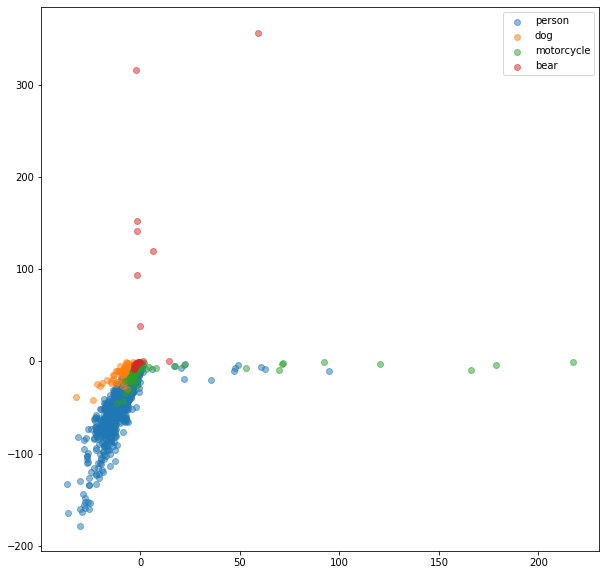

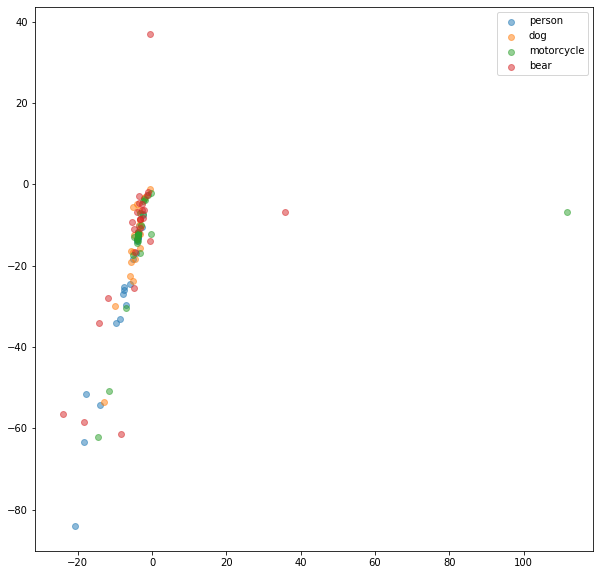

In [8]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(dev_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [9]:
torch.save(model.state_dict(), "baseline_rgb.pth")